In [0]:
%pylab inline
import os
import re
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


1. Загрузим данные за период c января 2015г. по  май 2016г.

In [0]:
#path = 'drive/My Drive/Colab Notebooks/yellow_taxi/'
path = '/home/andrei/Yandex.Disk/ML/Chapter_6/taxi/WEEK4/yellow_taxi/'

In [0]:
filelist = ['agg201606.csv', 'agg201605.csv', 'agg201604.csv', 'agg201603.csv', 'agg201602.csv', 'agg201601.csv', 
            'agg201512.csv', 'agg201511.csv', 'agg201510.csv', 'agg201509.csv', 'agg201508.csv', 'agg201507.csv',
           'agg201506.csv', 'agg201505.csv', 'agg201504.csv', 'agg201503.csv', 'agg201502.csv', 'agg201501.csv']

In [0]:
with open(path + 'list102.txt', 'r') as f:
    region_list = re.split('[,]', f.read())

region_list = [int(x) for x in region_list]
regions = pd.DataFrame(region_list, columns=['region_number'])

taxi = [pd.read_csv(path + files) for files in filelist]
taxi = pd.concat(taxi)

df = pd.merge(regions, taxi, on = 'region_number', how = 'inner')

df.reset_index(inplace = True)
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df = df.set_index('tpep_pickup_datetime')

In [0]:
y = (df.pivot_table(values='n', index='tpep_pickup_datetime' , columns='region_number', 
                       aggfunc= lambda x: x)).fillna(0)

column_names = ['r' + str(num) for num in region_list]
y.columns = column_names
y.head()

,r1075,r1076,r1077,r1125,r1126,r1127,r1128,r1129,r1130,r1131,...,r1630,r1684,r1733,r1734,r1783,r2068,r2069,r2118,r2119,r2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,102.0,115.0,60.0,103.0,305.0,479.0,499.0,716.0,987.0,324.0,...,14.0,0.0,1.0,40.0,37.0,33.0,5.0,97.0,9.0,71.0
2015-01-01 01:00:00,134.0,162.0,56.0,134.0,474.0,513.0,449.0,483.0,630.0,228.0,...,23.0,0.0,1.0,0.0,4.0,4.0,0.0,110.0,0.0,2.0
2015-01-01 02:00:00,99.0,179.0,39.0,127.0,372.0,409.0,391.0,443.0,475.0,180.0,...,48.0,0.0,2.0,1.0,2.0,0.0,0.0,5.0,0.0,1.0
2015-01-01 03:00:00,80.0,116.0,19.0,79.0,325.0,461.0,315.0,415.0,335.0,159.0,...,34.0,0.0,3.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0
2015-01-01 04:00:00,25.0,54.0,15.0,69.0,172.0,319.0,274.0,364.0,371.0,132.0,...,38.0,0.0,5.0,2.0,3.0,4.0,0.0,3.0,0.0,16.0


In [0]:
def fourier(T, K, period):
    si = np.zeros([T, K])
    ci = np.zeros([T, K])
    for i in range(K):
        si[:, i] = (np.sin((np.arange(1, T+1)) * 2 * np.pi * (i + 1) / period))
        ci[:, i]= (np.cos((np.arange(1, T+1)) * 2 * np.pi * (i + 1) / period))
    return si, ci 

In [0]:
tmp = y.copy()
tmp.shape

(13128, 102)

In [0]:
yK = 2
yperiod = 8766

wK = 50
wperiod = 168

dK = 10
dperiod = 24

start_date = '2015-01-10 00:00:00'
train_date = '2016-04-30 23:00:00'
test_date = '2016-05-31 23:00:00'
predict_date = '2016-06-30 23:00:00' 

In [27]:
%%time
#Получаем косинусы по дням, неделям, году

ysi, yci = fourier(tmp.shape[0], yK, yperiod)
wsi, wci = fourier(tmp.shape[0], wK, wperiod)
dsi, dci = fourier(tmp.shape[0], dK, dperiod)

index_list1 = pd.date_range(train_date, test_date, freq = 'H')
index_list2 = pd.date_range(test_date, predict_date, freq = 'H')
add_test = pd.DataFrame(index = index_list1)
add_predict = pd.DataFrame(index = index_list2)
add_test.index.name = 'tpep_pickup_datetime'
add_predict.index.name = 'tpep_pickup_datetime'

# Добавляем признаки в один датафрейм
tmp['weekend'] = [1 if (x.weekday() in [5,6]) else 0 for x in tmp.index]
tmp['month'] = tmp.index.month
tmp['day'] = tmp.index.day
tmp['hour'] = tmp.index.hour


for i in range(1, yK + 1):
    tmp['ysin' + str(i)] = ysi[: , i-1]
    tmp['ycos' + str(i)] = yci[: , i-1]
    features_c = 'ysin' +str(i) + ',' + 'ycos' +  str(i) + ','
    
for i in range(1, wK + 1):
    tmp['wsin' + str(i)] = wsi[: , i-1]
    tmp['wcos' + str(i)] = wci[: , i-1]
    features_c += 'wsin' +str(i) + ',' + 'wcos' +  str(i) + ','
    
for i in range(1, dK + 1):
    tmp['dsin' + str(i)] = dsi[: , i-1]
    tmp['dcos' + str(i)] = dci[: , i-1]
    features_c += 'dsin' +str(i) + ',' + 'dcos' +  str(i) + ',' 
    
for reg_num in tmp.columns[:len(region_list)]:
    features = ''
    tmp[reg_num + '_t1'] = tmp[reg_num].shift(1)
    tmp[reg_num + '_t2'] = tmp[reg_num].shift(2)
    tmp[reg_num + '_t3'] = tmp[reg_num].shift(3)
    tmp[reg_num + '_t4'] = tmp[reg_num].shift(4)
    tmp[reg_num + '_t5'] = tmp[reg_num].shift(5)
    tmp[reg_num + '_t6'] = tmp[reg_num].shift(6)
    tmp[reg_num + '_t24'] = tmp[reg_num].shift(24)
    tmp[reg_num + '_t48'] = tmp[reg_num].shift(48)
    tmp[reg_num + '_t72'] = tmp[reg_num].shift(72)
    
    features = features_c + 'month' + ',' + 'day' + ',' + 'hour' + ',' +'weekend' + ',' + '\'' + \
                 reg_num +'_t24' +'\'' + ',' +'\'' + reg_num + '_t48'+ '\'' + '\'' + reg_num + '_t72' +'\'' +\
                 reg_num +'_t1' +'\'' + ',' +'\'' + reg_num + '_t2'+ '\'' + '\'' + reg_num + '_t3' +'\'' +\
                 reg_num +'_t4' +'\'' + ',' +'\'' + reg_num + '_t5'+ '\'' + '\'' + reg_num + '_t6' +'\''
    features = re.findall('\w+', features)
    
 #  Обучающая выборка 
    X_train = tmp[features].loc[start_date : train_date].values
    labels_train = tmp[reg_num].loc[start_date : train_date].values
    
 #  Тестовая выборка 
    X_test = tmp.loc[train_date : test_date][features].values
    labels_test = tmp[reg_num].loc[train_date : test_date].values
    
 #  Итоговая выборка
    X_predict = tmp.loc[test_date : ][features].values    
    
    
    clf = LinearRegression(n_jobs= -1).fit(X_train, labels_train)
    add_test[reg_num] = clf.predict(X_test)
    add_predict[reg_num] = clf.predict(X_predict)
    #clf = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 42).fit(X_train, labels_train)
    #clf = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state= 42).fit(X_train, labels_train)
    
    #print(clf.score(X_test, tmp.loc[train_date: test_date]['r1075'].values))

CPU times: user 25.3 s, sys: 11.6 s, total: 36.9 s
Wall time: 18.6 s


In [0]:
#LinearRegression
0.9054973825780869
CPU times: user 995 ms, sys: 19.9 ms, total: 1.01 s
Wall time: 344 ms
    
#RandomForestRegressor
0.9089264740163402
CPU times: user 1min 48s, sys: 170 ms, total: 1min 48s
Wall time: 28 s

# Разница в точности небольшая, но существенная разница в скорости обучения. 
# Поэтому для предсказания используем LinearRegression


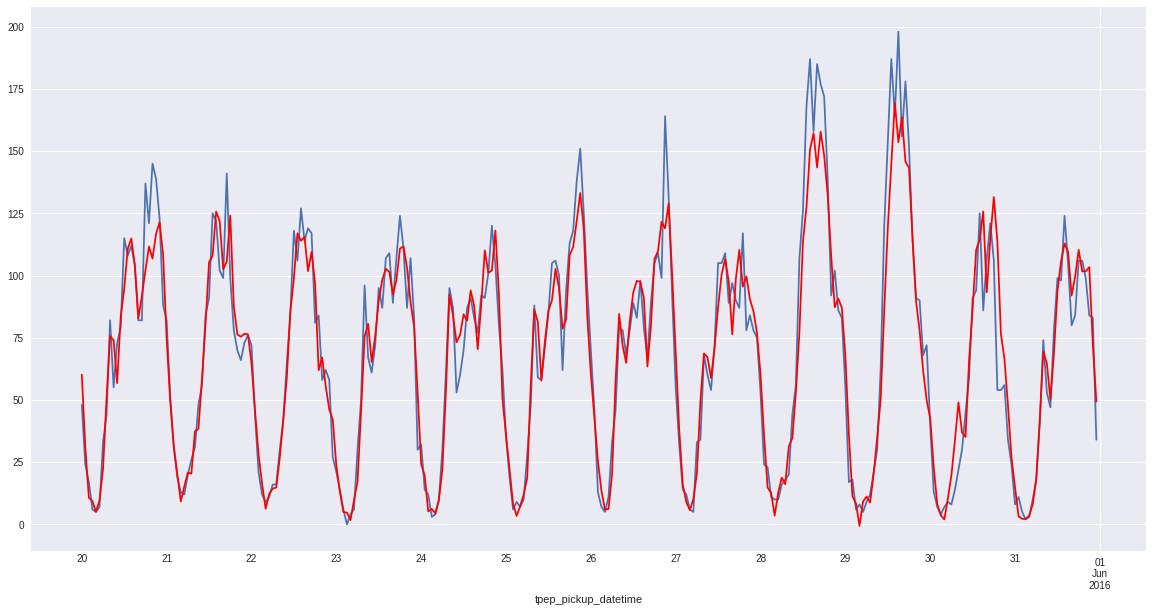

In [28]:
#LinearRegression for May
plt.figure(figsize = (20, 10))
tmp.loc['2016-05-20 00:00:00' : '2016-05-31 23:00:00']['r1075'].plot()
add_test.loc['2016-05-20 00:00:00' : '2016-05-31 23:00:00']['r1075'].plot(c= 'r')

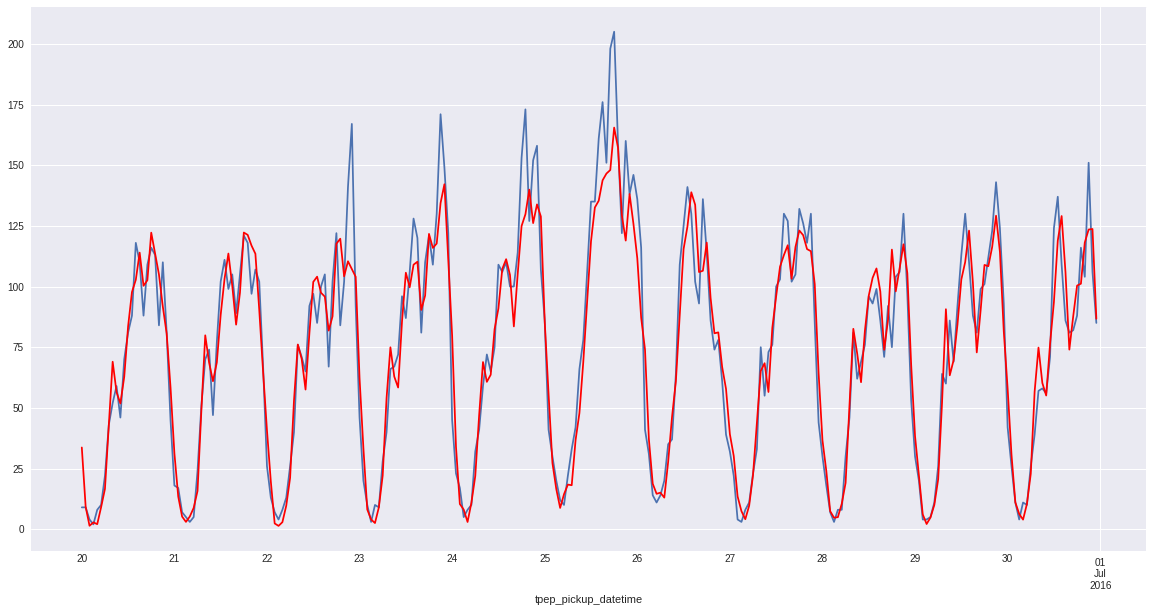

In [29]:
#LinearRegression for June
plt.figure(figsize = (20, 10))
tmp.loc['2016-06-20 00:00:00' : '2016-06-30 23:00:00']['r1075'].plot()
add_predict.loc['2016-06-20 00:00:00' : '2016-06-30 23:00:00']['r1075'] .plot(c = 'r')

4. Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
$Q_{may} =\frac1{R* 739* 6} \sum\limits_{r=1}^{R} \sum_{T=2016.04.30\,23:00}^{2016.05.31\,17:00} \sum_{i=1}^6 \left| \hat{y}^r_{T|T+i} - y_{T+i}^r \right|$.

Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу Q, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

In [0]:
date_list = pd.date_range('2016-04-30 23:00', '2016-05-31 17:00', freq = 'H')

In [0]:
add_predict[add_predict[:] < 0] = 0
add_test[add_test[:] < 0] = 0

In [0]:
add_test.to_csv(path + 'testw5.csv', index= False)
add_predict.to_csv(path + 'predictw5.csv', index= False)

In [42]:
# Подсчитаем ошибку
Qmay = 0
for reg_num in column_names:
    for date in date_list:
        for t in range(1,7):
            Qmay += np.abs(add_test.loc[date + timedelta(hours = t)][reg_num] - y.loc[date + timedelta(hours = t)][reg_num])          
Qmay = Qmay /( 120. * 739. * 6) 
Qmay 

12.468974048926984

ошибка уменьшилась

5.  Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [0]:
date_june = pd.date_range('2016-05-31 23:00', '2016-06-30 17:00', freq = 'H')

In [45]:
add_predict.columns = region_list
add_predict.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-31 23:00:00,49.346658,62.199731,56.544532,49.161498,117.261040,228.235498,331.943930,372.823378,437.736889,104.011004,...,3.785980,5.661316,8.166777,396.232423,229.701353,165.641889,19.164433,230.897070,58.590319,109.915373
2016-06-01 00:00:00,18.756370,40.191406,26.822557,28.495181,67.887377,101.798148,189.439508,231.863010,360.600925,70.518738,...,6.360534,2.598046,4.425906,193.346536,72.913068,94.855753,9.135783,187.907287,28.340984,91.130464
2016-06-01 01:00:00,12.929083,14.973821,8.368393,19.305184,30.927101,76.557153,77.020476,119.345330,266.271326,36.539974,...,7.843339,3.368389,1.900427,77.448482,15.635132,31.630021,3.750753,81.991474,17.507615,43.776140
2016-06-01 02:00:00,3.697725,4.786678,0.000000,9.218510,17.275142,46.308086,67.093415,86.303751,240.024865,14.815521,...,5.625909,2.051202,0.232911,52.254272,5.140961,8.423176,0.727968,35.866149,14.377065,10.597546
2016-06-01 03:00:00,1.281683,16.847256,2.574810,9.955603,9.880095,21.007788,38.494919,94.728428,232.760022,20.597520,...,4.165878,1.192613,0.403946,33.196356,4.612372,7.895448,0.559462,36.182064,0.046449,1.123466


In [0]:
forecast_list = []
for t in date_june:
    for i in add_predict.columns[:]:
        for j in range(1,7):
            id = str(i)+'_'+str(t)[:10]+'_'+str(int(str(t)[11:13]))+'_'+str(j)
            val = add_predict.loc[t + timedelta(hours=j), i]
            forecast_list.append([id, round(val, 0)])

In [0]:
forecast_pd = pd.DataFrame(forecast_list)
forecast_pd.columns = ['id', 'y']

In [0]:
forecast_pd.to_csv(path + 'submission.csv', index=False)

6. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

https://inclass.kaggle.com/c/yellowtaxi/submissions?sortBy=date&group=all&page=1

Lobanov (11 -й в списке)
